In [5]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']
News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las

In [6]:
# =====================================================================
# 1. Imports & Initialization
# =====================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

# Convert and verify date columns
news_embeddings['news_date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['speech_date'] = pd.to_datetime(speeches_embeddings['date'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================================================================
# 2. Temporal Pair Generation (UPDATED)
# =====================================================================
def generate_temporal_pairs(news_df, speeches_df, window_days=7):
    """Generate news-speech pairs within a symmetric temporal window (-7 to +7 days)"""
    pairs = []
    chunk_size = 2000
    news_chunks = np.array_split(news_df, len(news_df) // chunk_size + 1)
    
    for chunk in news_chunks:
        for _, row in chunk.iterrows():
            news_date = row['news_date']
            start_date = news_date - pd.Timedelta(days=window_days) 
            end_date = news_date + pd.Timedelta(days=window_days)  
            
            mask = (speeches_df['speech_date'] >= start_date) & (speeches_df['speech_date'] <= end_date)
            speech_ids = speeches_df[mask].index.tolist()
            pairs.extend([(row.name, s_id) for s_id in speech_ids])
    
    return pd.DataFrame(pairs, columns=['news_id', 'speech_id'])


alignment_df = generate_temporal_pairs(news_embeddings, speeches_embeddings)

# =====================================================================
# 3. Memory-Optimized Embedding Processing (Unchanged)
# =====================================================================
def load_embeddings_half(df, col_name):
    embeddings = []
    for i, row in df.iterrows():
        if isinstance(row[col_name], str):
            arr = np.fromstring(row[col_name].strip("[]"), sep=" ", dtype=np.float16)
        else:
            arr = np.array(row[col_name], dtype=np.float16)
        embeddings.append(torch.tensor(arr, device=device).half())
        if i % 1000 == 0: torch.cuda.empty_cache()
    return torch.stack(embeddings)

news_tensor = load_embeddings_half(news_embeddings, 'news_embeddings')
speeches_tensor = load_embeddings_half(speeches_embeddings, 'speech_embeddings')

# =====================================================================
# 4. Batched Similarity Computation (Unchanged)
# =====================================================================
def compute_cosine_similarities(pairs_df, news_emb, speech_emb, batch_size=8192):
    news_norm = F.normalize(news_emb, p=2, dim=1)
    speech_norm = F.normalize(speech_emb, p=2, dim=1)
    similarities = []
    for i in range(0, len(pairs_df), batch_size):
        batch = pairs_df.iloc[i:i+batch_size]
        news_batch = news_norm[batch['news_id'].values]
        speech_batch = speech_norm[batch['speech_id'].values]
        similarities.append(F.cosine_similarity(news_batch, speech_batch).cpu().numpy())
        del news_batch, speech_batch
        torch.cuda.empty_cache()
    return np.concatenate(similarities)

alignment_df['cosine_similarity'] = compute_cosine_similarities(alignment_df, news_tensor, speeches_tensor)

# =====================================================================
# 5. Enrich with Temporal Metadata (CORRECTED VERSION)
# =====================================================================
def add_temporal_features(pairs_df, news_df, speeches_df):
    pairs_df = pairs_df.merge(
        news_df[['news_date']],
        left_on='news_id',
        right_index=True
    ).merge(
        speeches_df[['speech_date']],
        left_on='speech_id',
        right_index=True
    )
    pairs_df['days_diff'] = (pairs_df['news_date'] - pairs_df['speech_date']).dt.days
    return pairs_df

enriched_df = add_temporal_features(alignment_df, news_embeddings, speeches_embeddings)

# =====================================================================
# 6. Save Processed Data (Unchanged)
# =====================================================================
enriched_df.to_parquet('news_speech_similarities.parquet', engine='pyarrow', compression='zstd')
print("Processing complete. Results saved with columns:", enriched_df.columns.tolist())

Using device: cuda


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing complete. Results saved with columns: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff']


Data types:
 news_id                       int64
speech_id                     int64
cosine_similarity           float32
news_date            datetime64[ns]
speech_date          datetime64[ns]
days_diff                     int64
dtype: object


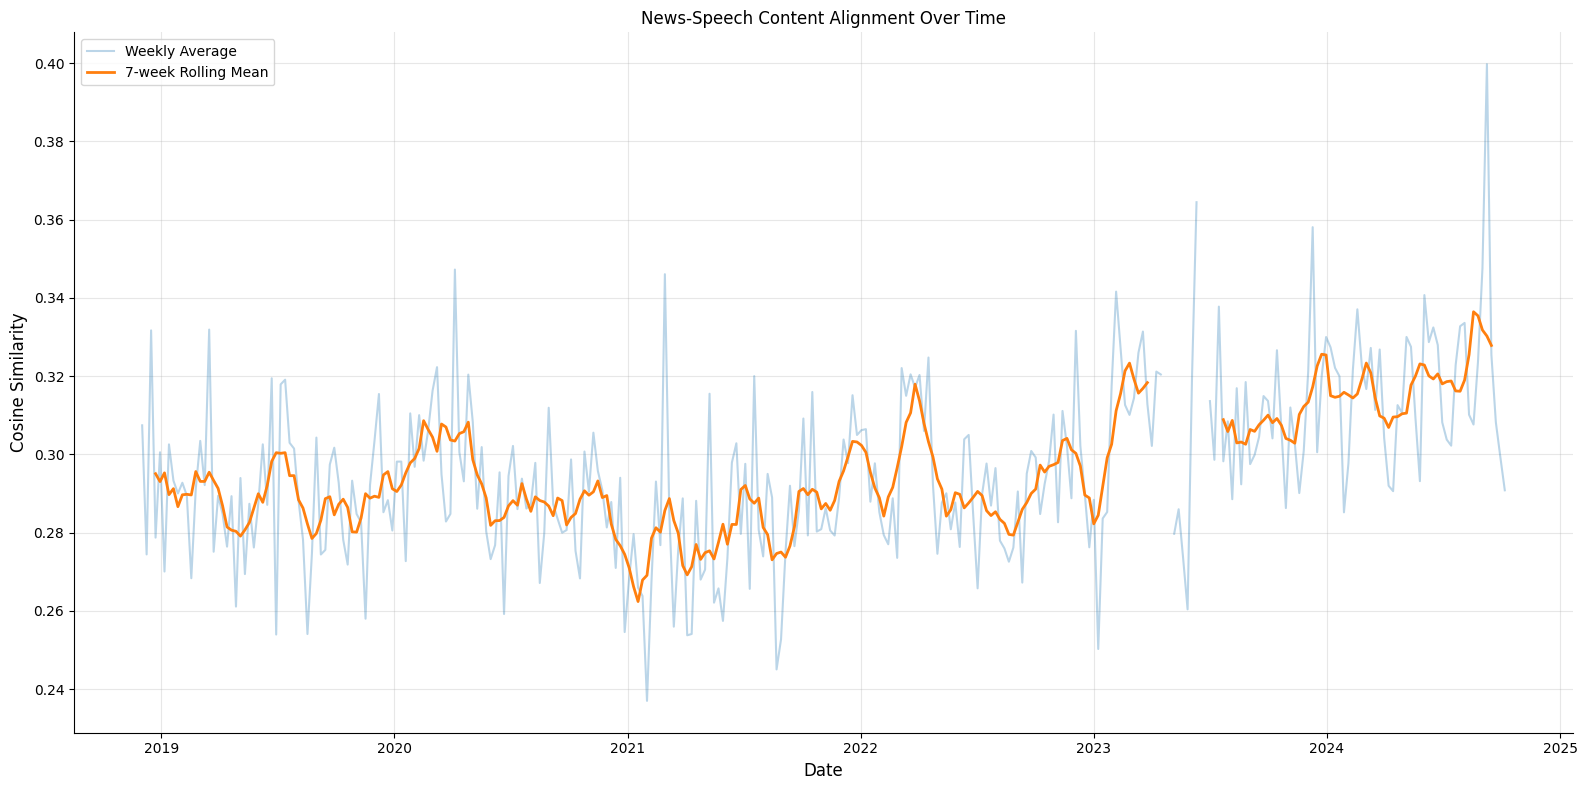

In [7]:
# =====================================================================
# 1. Imports & Data Loading (MODIFIED)
# =====================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_safe_data():
    """Load data with proper dtype conversions"""
    df = pd.read_parquet('news_speech_similarities.parquet').astype({
        'news_id': 'int64',
        'speech_id': 'int64',
        'cosine_similarity': 'float32'  # Convert from float16 to float32
    })
    df['news_date'] = pd.to_datetime(df['news_date'])
    return df

# Load processed data
df = load_safe_data()

# =====================================================================
# 2. Temporal Trend Analysis (FIXED VERSION)
# =====================================================================
def plot_temporal_trends(df, resample_freq='W', rolling_window=7):
    """Plot similarity trends with type-safe processing"""
    plt.figure(figsize=(16, 8))
    
    # Ensure float32 type
    temp_df = df[['news_date', 'cosine_similarity']].copy()
    temp_df['cosine_similarity'] = temp_df['cosine_similarity'].astype('float32')
    
    # Resample data
    df_temp = temp_df.set_index('news_date')
    resampled = df_temp['cosine_similarity'].resample(resample_freq).mean()
    
    # Create rolling average
    rolling_mean = resampled.rolling(window=rolling_window, center=True).mean()
    
    # Plot with enhanced formatting
    plt.plot(resampled.index, resampled.values, 
            alpha=0.3, label='Weekly Average')
    plt.plot(rolling_mean.index, rolling_mean.values,
            linewidth=2, label=f'{rolling_window}-week Rolling Mean')
    
    plt.title('News-Speech Content Alignment Over Time')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cosine Similarity', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

# =====================================================================
# 3. Execution (MODIFIED)
# =====================================================================
if __name__ == "__main__":
    df = load_safe_data()
    
    # Verify data types
    print("Data types:\n", df.dtypes)
    
    # Plot temporal trends only
    plot_temporal_trends(df)

<ipython-input-11-623e9d1ac9f2>:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()


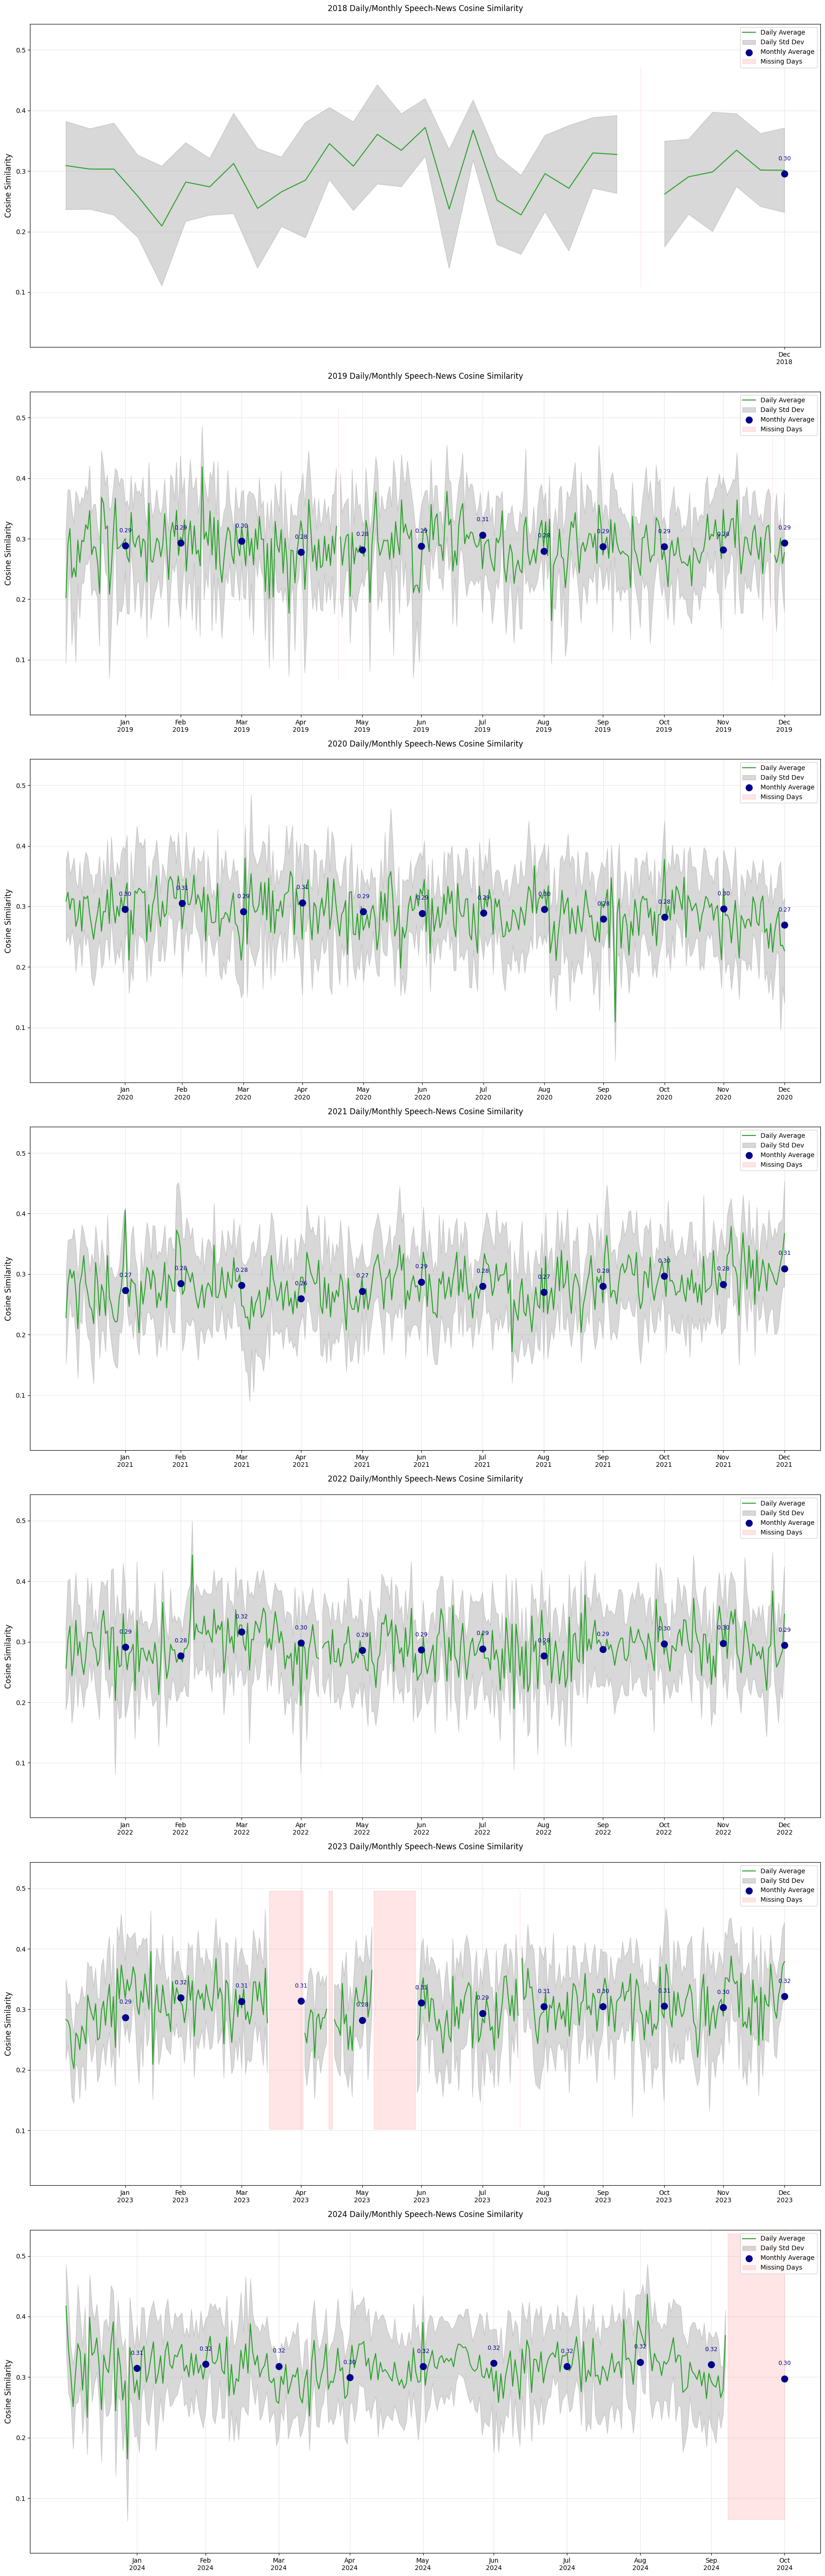

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load processed data
df = pd.read_parquet('news_speech_similarities.parquet') #We can use this code when we compute everything again, else we have to roead the parquet
#df = pd.read_parquet(SIMILARITIES_PATH)
# Convert to datetime and normalize (remove time components)
df['news_date'] = pd.to_datetime(df['news_date']).dt.normalize()
df['year'] = df['news_date'].dt.year

# Create daily aggregates with std dev
daily_agg = df.groupby('news_date')['cosine_similarity'].agg(['mean', 'std']).reset_index()
daily_agg.columns = ['date', 'cosine_similarity', 'std_dev']

# Extend full_dates to include October 2024 explicitly
end_date = pd.to_datetime('2024-10-31')  # Adjust as needed
full_dates = pd.date_range(
    start=daily_agg['date'].min(), 
    end=end_date, 
    freq='D'
)
daily_agg = daily_agg.set_index('date').reindex(full_dates).reset_index().rename(columns={'index': 'date'})

# Calculate bounds
daily_agg['upper_bound'] = daily_agg['cosine_similarity'] + daily_agg['std_dev'].fillna(0)
daily_agg['lower_bound'] = daily_agg['cosine_similarity'] - daily_agg['std_dev'].fillna(0)

# Create monthly aggregates (fill NaN with 0 for plotting)
monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()
monthly_agg['month_label'] = monthly_agg['date'].dt.strftime('%b\n%Y')

# Get unique years present in data
years = daily_agg['date'].dt.year.unique()

# Set up plot
plt.figure(figsize=(18, 8 * len(years)))

for i, year in enumerate(years, 1):
    year_mask = daily_agg['date'].dt.year == year
    yearly_daily = daily_agg[year_mask]
    yearly_monthly = monthly_agg[monthly_agg['date'].dt.year == year]
    
    if yearly_daily.empty:
        continue
    
    ax = plt.subplot(len(years), 1, i)
    
    # Daily plot with variability
    ax.plot(yearly_daily['date'], 
            yearly_daily['cosine_similarity'], 
            color='#2ca02c', 
            linewidth=1.5,
            label='Daily Average')
    
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['upper_bound'],
                    yearly_daily['lower_bound'],
                    color='gray', alpha=0.3, 
                    label='Daily Std Dev')
    
    # Monthly markers (plot even if value is 0)
    ax.scatter(yearly_monthly['date'], 
               yearly_monthly['cosine_similarity'],
               color='darkblue', 
               s=100,
               zorder=5,
               label='Monthly Average')
    
    # Annotate monthly values (skip if 0)
    for _, row in yearly_monthly.iterrows():
        if row['cosine_similarity'] != 0:
            ax.text(row['date'], row['cosine_similarity']+0.02,
                    f"{row['cosine_similarity']:.2f}",
                    ha='center', va='bottom',
                    fontsize=9, color='darkblue')
    
    # Highlight missing days
    missing_mask = yearly_daily['cosine_similarity'].isna()
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['cosine_similarity'].min() - 0.1,
                    yearly_daily['cosine_similarity'].max() + 0.1,
                    where=missing_mask,
                    color='red', alpha=0.1,
                    label='Missing Days')
    
    # Formatting
    ax.set_title(f'{year} Daily/Monthly Speech-News Cosine Similarity', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set monthly x-ticks
    ax.set_xticks(yearly_monthly['date'])
    ax.set_xticklabels(yearly_monthly['month_label'])
    
    # Set y-axis limits
    y_min = max(daily_agg['cosine_similarity'].min() - 0.1, 0)
    y_max = min(daily_agg['cosine_similarity'].max() + 0.1, 1)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [9]:
import re

def extract_outlet(url):
    """Extract outlet name from URL with improved pattern matching"""
    patterns = [
        r"https?://(?:www\.)?([^/.]+)\.",
        r"https?://([^/]+)/",
        r"([a-z0-9-]+)\.(com|org|net|edu|gov)"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, url, re.IGNORECASE)
        if match:
            return match.group(1).lower()
    return "unknown"

# Add outlet column to news_embeddings
news_embeddings['outlet'] = news_embeddings['Link'].apply(extract_outlet)